<a href="https://colab.research.google.com/github/TimurMMD/Dissertation_Thesis/blob/main/TabNet_return.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.7 MB/s eta 0:00:00


In [39]:
import pandas as pd
from google.colab import files
import zipfile
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.metrics import r2_score

# Data Preparation

## Load the Dataset: Import data into a pandas DataFrame.
## Handle Missing Data: Fill any missing values (e.g., with forward or backward fill, or by using the mean).
## Drop Non-Predictive Columns: Remove any columns that are not predictive, such as dates or IDs.

In [6]:
# Define the file name you uploaded
zip_file = '/content/financial_data_refine_changed.zip'

# Extract the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/csv_files_refine')

# Check files
os.listdir('/content/csv_files_refine')

['financial_data_refine']

In [8]:
# Specify the path to the folder where the CSVs are located
path = '/content/csv_files_refine/financial_data_refine'

# Get all CSV file paths with *_final.csv pattern
all_files = glob.glob(path + "/*_final.csv")

# Combine all CSVs into one DataFrame, adding the 'ticker' column
combined_df = pd.concat((pd.read_csv(f).assign(ticker=f.split('/')[-1].split('_final')[0]) for f in all_files), ignore_index=True)

# Check the combined dataset
print(combined_df.head())

         date  freeCashFlow  current_ratio  quick_ratio  debt_to_equity  \
0  2020-03-31 -1.278000e+09       0.671127     0.452011        2.386756   
1  2020-06-30 -4.680000e+08       0.553445     0.356381        2.494020   
2  2020-09-30  1.104000e+09       0.519919     0.328820        2.480416   
3  2020-12-31 -4.090000e+08       0.532475     0.338240        2.360187   
4  2021-03-31 -1.270000e+08       0.490856     0.313391        2.361827   

   interest_coverage_ratio  gross_profit_margin  operating_income_margin  \
0                 2.865699             0.498235                 0.250126   
1                -1.182310             0.490684                 0.217119   
2                 3.614943             0.503050                 0.269900   
3                 2.175701             0.443829                 0.012809   
4                 2.915888             0.492520                 0.235772   

   net_profit_margin       ROA       ROE  asset_turnover_ratio  \
0           0.157674  0.00

In [28]:
# Making the training dataset of the data before 2024, and others 2 quarters as testing
train_df = combined_df[combined_df['date'] < '2024-01-01']
test_df = combined_df[combined_df['date'] >= '2024-01-01']

In [29]:
# Drop unnecessary columns
train_df.drop(columns = ['date', 'ticker', 'close'], inplace = True)
test_df.drop(columns = ['date', 'ticker', 'close'], inplace = True)

<ipython-input-29-fb2704bb9abe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns = ['date', 'ticker', 'close'], inplace = True)
<ipython-input-29-fb2704bb9abe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns = ['date', 'ticker', 'close'], inplace = True)


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5957 entries, 0 to 7401
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   freeCashFlow                       5957 non-null   float64
 1   current_ratio                      5946 non-null   float64
 2   quick_ratio                        5946 non-null   float64
 3   debt_to_equity                     5946 non-null   float64
 4   interest_coverage_ratio            5947 non-null   float64
 5   gross_profit_margin                5947 non-null   float64
 6   operating_income_margin            5947 non-null   float64
 7   net_profit_margin                  5947 non-null   float64
 8   ROA                                5949 non-null   float64
 9   ROE                                5949 non-null   float64
 10  asset_turnover_ratio               5949 non-null   float64
 11  operating_cash_flow_to_total_debt  5946 non-null   float64
 1

In [30]:
# Replace infinite values with NaN
train_df = train_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.replace([np.inf, -np.inf], np.nan)

# Fill NaN values using interpolation, and fallback to column mean if still NaN
train_df = train_df.interpolate(method='linear', axis=0).fillna(train_df.mean())
test_df = test_df.interpolate(method='linear', axis=0).fillna(test_df.mean())

# Split the Data

## Define Target and Features: Separate features (e.g., financial indicators) from the target variable (e.g., returns).
## Train-Test Split: Split data into a training set and a test set. Since this is a time series or financial data, use chronological split (e.g., all data before 2024 as training, 2024 data as testing) to avoid data leakage.

In [31]:
# Splitting data and the return column is our target column
X_train = train_df.drop(columns=['return'])
y_train = train_df['return']
X_test = test_df.drop(columns=['return'])
y_test = test_df['return']

# Scaling

## Initialize Scalers: Use MinMaxScaler or StandardScaler to scale features and target variable separately.
## Fit on Training Data: Fit the scaler on the training data and transform both the training and test data. This ensures that the test data does not influence the scaling parameters.
## Scale the Target Variable: Scale the target variable (y) separately, since it needs to be scaled back later for real predictions.

In [32]:
# Initialize the scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler only on the training data and transform both train and test data
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [33]:
# Convert scaled data back to DataFrame to maintain feature names (optional, but helpful for tracking features)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [35]:
# Reshape y to 2D for scaling, then scale
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


In [36]:
# Convert data to numpy arrays (TabNet works with numpy arrays)
X_train_np = X_train_scaled.values
X_test_np = X_test_scaled.values


# Sequence Generation for Time Series (Optional)

## Create Sequences: If your model needs sequential data (like an LSTM), generate sequences by transforming each feature into a series of values over a chosen window (e.g., quarterly).
## Define X and y: For sequence models, make sure that both features (X) and target (y) align in terms of sequence format.

In [87]:
n_timesteps = 1  # Number of quarters in each sequence (you can change this)
n_features = X_train_scaled.shape[1]  # Number of features in the dataset
batch_size = 32
epochs = 50
learning_rate = 0.001
# Function to create sequences and labels
def create_sequences(data, n_timesteps):
    X, y = [], []
    for i in range(len(data) - n_timesteps -1):
        X.append(data[i:i + n_timesteps, :-1])  # All features except target
        y.append(data[i + n_timesteps + 1, -1])  # Target variable (e.g., return)
    return np.array(X), np.array(y)

In [83]:
scaler = MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)

In [88]:
# Prepare training and testing sequences
X_train, y_train = create_sequences(train_df_scaled, n_timesteps)
X_test, y_test = create_sequences(test_df_scaled, n_timesteps)

# Model Setup with TabNet

## Initialize TabNet Regressor: Set up the TabNet model with appropriate hyperparameters.
## Train the Model: Train the model on the training dataset using X_train and y_train.

In [54]:
!pip install --upgrade pytorch_tabnet

In [66]:
# Initialize TabNet Regressor
tabnet_model = TabNetRegressor()


# Train the model
tabnet_model.fit(
    X_train=X_train_np,
    y_train=y_train_scaled,
    eval_set=[(X_test_np, y_test_scaled)],
    eval_metric=['mae', 'rmse', 'mse'],          # We can also use MAE, MSE, etc.
    max_epochs=1000,
    patience = 500, # Stop if no improvement after 20 epochs
    batch_size=256,
    virtual_batch_size=64,
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76108 | val_0_mae: 0.12512 | val_0_rmse: 0.14671 | val_0_mse: 0.02152 |  0:00:01s
epoch 1  | loss: 0.08957 | val_0_mae: 0.06759 | val_0_rmse: 0.09258 | val_0_mse: 0.00857 |  0:00:02s
epoch 2  | loss: 0.02455 | val_0_mae: 0.06191 | val_0_rmse: 0.08656 | val_0_mse: 0.00749 |  0:00:03s
epoch 3  | loss: 0.01527 | val_0_mae: 0.07872 | val_0_rmse: 0.10367 | val_0_mse: 0.01075 |  0:00:04s
epoch 4  | loss: 0.01312 | val_0_mae: 0.05913 | val_0_rmse: 0.08315 | val_0_mse: 0.00691 |  0:00:04s
epoch 5  | loss: 0.01117 | val_0_mae: 0.05979 | val_0_rmse: 0.0832  | val_0_mse: 0.00692 |  0:00:05s
epoch 6  | loss: 0.01111 | val_0_mae: 0.06383 | val_0_rmse: 0.08672 | val_0_mse: 0.00752 |  0:00:06s
epoch 7  | loss: 0.01113 | val_0_mae: 0.05909 | val_0_rmse: 0.08317 | val_0_mse: 0.00692 |  0:00:07s
epoch 8  | loss: 0.01093 | val_0_mae: 0.05911 | val_0_rmse: 0.0829  | val_0_mse: 0.00687 |  0:00:08s
epoch 9  | loss: 0.01046 | val_0_mae: 0.05919 | val_0_rmse: 0.08323 | val_0_mse: 0.00693 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Evaluation

## Generate Predictions on Test Set: Use the trained model to predict y_test and get the scaled predictions.
## Inverse Transform the Predictions: Transform the scaled predictions back to the original target scale using the scaler_y.inverse_transform() method.
## Evaluate Performance: Use evaluation metrics like R² (for regression accuracy) to assess model performance.

In [40]:
y_test_scaled

array([[0.44921158],
       [0.47131128],
       [0.58388977],
       ...,
       [0.44683485],
       [0.49315005],
       [0.41515887]])

In [67]:
# Make predictions on test set
y_pred = tabnet_model.predict(X_test_np)

y_pred_real = scaler_y.inverse_transform(y_pred)

# Evaluate the model using R² score
r2 = r2_score(y_test, y_pred_real)
print(f"R² Score: {r2}")


R² Score: 0.017700444810294536


In [68]:
print("######## Y testing before scaling (original) ########")
print(y_test.describe())
print("######## Y testing after scaling ####################")
print(pd.DataFrame(y_test_scaled).describe())
print("######## Y prediction before rescaling ##############")
print(pd.DataFrame(y_pred).describe())
print("######## Y prediction after rescaling ###############")
print(pd.DataFrame(y_pred_real).describe())

######## Y testing before scaling (original) ########
count    1447.000000
mean        0.025506
std         0.149190
min        -0.836655
25%        -0.060109
50%         0.018869
75%         0.105390
max         2.229665
Name: return, dtype: float64
######## Y testing after scaling ####################
                 0
count  1447.000000
mean      0.465263
std       0.082844
min      -0.013490
25%       0.417722
50%       0.461578
75%       0.509623
max       1.689222
######## Y prediction before rescaling ##############
                 0
count  1447.000000
mean      0.461570
std       0.008915
min       0.437716
25%       0.459430
50%       0.460217
75%       0.461672
max       0.724138
######## Y prediction after rescaling ###############
                 0
count  1447.000000
mean      0.018854
std       0.016055
min      -0.024103
25%       0.015002
50%       0.016419
75%       0.019039
max       0.491699


In [51]:
y_pred

array([[0.464327  ],
       [0.46419102],
       [0.4639785 ],
       ...,
       [0.4642815 ],
       [0.46413696],
       [0.4641221 ]], dtype=float32)

# Final Prediction on Real Data

## Prepare New Data: When using new data for live predictions (e.g., current quarter data), follow the same preprocessing steps (dropping unnecessary columns, scaling).
## Generate Predictions: Use the trained model to make predictions on this new, unseen data.
## Inverse Transform for Real Values: Convert these predictions back to the original scale to get the actual return values

# SimpleRNN
## Build SimpleRNN from keras to make a regression prediction.


In [70]:
batch_size = 32
n_samples = X_train_scaled.shape[0]
n_timesteps = X_train_scaled.shape[1]
n_steps = y_train_scaled.shape[1]
n_features = 1
X_train_rs = X_train_np.reshape(n_samples, n_timesteps, n_features )
X_test_rs = X_test_np.reshape(X_test_scaled.shape[0], n_timesteps, n_features )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 8)                   │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89 (356.00 B)

 Trainable params: 89 (356.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0875 - mean_absolute_error: 0.0875 - val_loss: 0.0779 - val_mean_absolute_error: 0.0779
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0690 - mean_absolute_error: 0.0690 - val_loss: 0.0783 - val_mean_absolute_error: 0.0783
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0691 - mean_absolute_error: 0.0691 - val_loss: 0.0783 - val_mean_absolute_error: 0.0783
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0691 - mean_absolute_error: 0.0691 - val_loss: 0.0780 - val_mean_absolute_error: 0.0780
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0690 - mean_absolute_error: 0.0690 - val_loss: 0.0784 - val_mean_absolute_error: 0.0784
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0690 - mean_absolute_error: 0.0690 - val_loss: 0.0784 - val_mean_absolute_error: 0.0784
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0690 - mean_absolute_error: 0.0690 - v

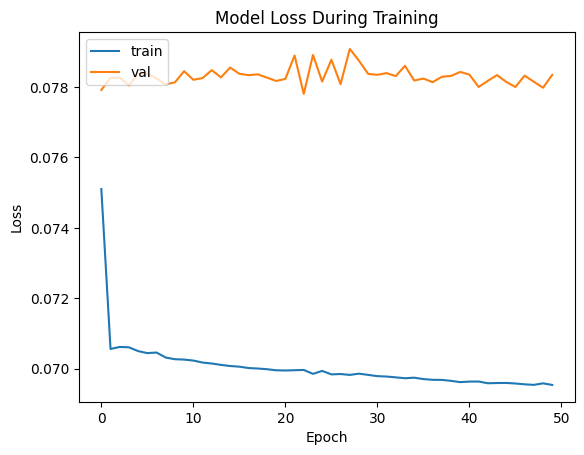

In [71]:
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define the Simple RNN model
simple_model = Sequential([
    SimpleRNN(8, activation='tanh', input_shape=(n_timesteps, n_features)),
    Dense(1)  # Single output node for return prediction
])

simple_model.summary()

# Compile the model
simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error',  # MAE loss function
    metrics=['mean_absolute_error']  # Track MAE during training
)

# Train the model
smod_history = simple_model.fit(
    X_train_rs, y_train_scaled,
    validation_split=0.2,
    epochs=50,  # Increased number of epochs for better learning
    batch_size=batch_size,
    shuffle=True
)

# Predict on the test set
preds_scaled = simple_model.predict(X_test_rs)

# Reverse scaling of predictions and actual values
preds = scaler_y.inverse_transform(preds_scaled)  # Assuming `scaler_y` is your y-target scaler
# y_test_rescaled = scaler_y.inverse_transform(y_test)

# Calculate R² score
r2 = r2_score(y_test, preds)
print("R² score:", r2)

# Plot training & validation loss history
plt.plot(smod_history.history['loss'], label='Training Loss')
plt.plot(smod_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [73]:
print(pd.DataFrame(preds).describe())
print(pd.DataFrame(preds_scaled).describe())

                 0
count  1447.000000
mean     -0.004376
std       0.009834
min      -0.307941
25%      -0.004671
50%      -0.004355
75%      -0.003930
max       0.126289
                 0
count  1447.000000
mean      0.448670
std       0.005461
min       0.280102
25%       0.448506
50%       0.448682
75%       0.448917
max       0.521227


# SimpleRNN might be too simple for my datatype

# Personal builded LSTM

In [94]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

In [96]:
# Build the LSTM model
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    LSTM(75, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(25, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression (single output for return prediction)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 1, 100)              │          46,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 1, 75)               │          52,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 75)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 1, 50)               │          25,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 1, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 1, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 1, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 25)                  │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 192,626 (752.45 KB)

 Trainable params: 192,626 (752.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.1100 - mean_absolute_error: 0.2773 - val_loss: 0.0112 - val_mean_absolute_error: 0.0771
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0111 - mean_absolute_error: 0.0812 - val_loss: 0.0112 - val_mean_absolute_error: 0.0771
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0110 - mean_absolute_error: 0.0798 - val_loss: 0.0114 - val_mean_absolute_error: 0.0775
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0110 - mean_absolute_error: 0.0794 - val_loss: 0.0113 - val_mean_absolute_error: 0.0772
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0109 - mean_absolute_error: 0.0794 - val_loss: 0.0113 - val_mean_absolute_error: 0.0773
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0105 - mean_absolute_error: 0.0778 - val_loss: 0.0114 - val_mean_absolute_error: 0.0775
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0101 - mean_absolute_error: 0.

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
R² Score: -0.000497158676563414


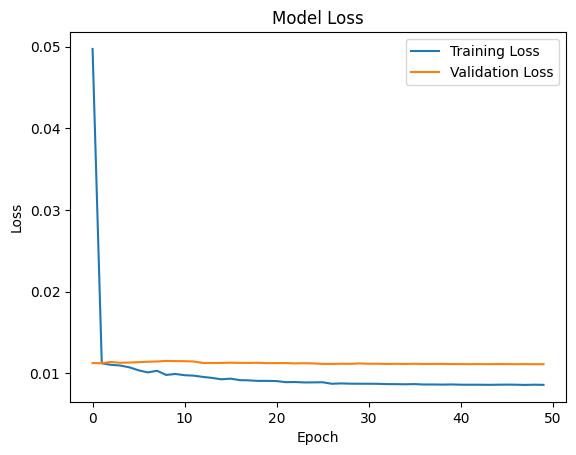

In [99]:
# Make predictions
y_pred_scaled = model.predict(X_test)

# Rescale predictions and actual values back to original scale
num_original_features = 16
y_pred = scaler.inverse_transform(np.concatenate([np.zeros((y_pred_scaled.shape[0], num_original_features - 1)), y_pred_scaled], axis=1))[:, -1]
y_test_original = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], num_original_features - 1)), y_test.reshape(-1, 1)], axis=1))[:, -1]

# Evaluate the model using R² score
r2 = r2_score(y_test_original, y_pred)
print(f'R² Score: {r2}')

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [102]:
pd.DataFrame(y_pred_scaled).describe()

,0
count,1.445000e+03
mean,4.634221e-01
std,3.941611e-07
min,4.634101e-01
25%,4.634221e-01
50%,4.634221e-01
75%,4.634221e-01
max,4.634228e-01
